In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
# 18 states : 
    # state 0 : offer accepted 
    # state 1: offer rejected
    # state 2-17 : listing price raised in 1% increments till 15%

# 17 actions : 
    # action 0: bid same
    # action 1-15: bid higher in 1% increments till 15%
    # action 16: terminating action (do nothing, end bidding)
    

In [932]:
# Without initial state
# 17 states : 
    # state 0 : offer accepted 
    # state 1: offer rejected
    # state 2-16 : listing price raised in 1% increments till 15%

# 17 actions : 
    # action 0: bid same
    # action 1-15: bid higher in 1% increments till 15%
    # action 16: terminating action (do nothing, end bidding)
    
# -ve reward for going over budget
    

def generate(list_price, budgets, other_bids):
    normal_bids = np.random.normal(list_price, 0.15*list_price, 1000)
    bids = []
    
    for i, a in enumerate(budgets):
        if len(normal_bids[(normal_bids <= a) & (normal_bids >= other_bids[i])]) > 0:
            bids += list(np.random.choice(normal_bids[(normal_bids <= a) & (normal_bids >= other_bids[i])], 1))
        else:
            bids += [other_bids[i]]

    return np.array(bids)

def raise_bid(list_price, agent_bids):
    # whether the seller asks for more offers depending on the average bid
    if np.mean(agent_bids) > list_price:
        return 1
    else: 
        return 0
    
def choose_action(A):
    # chooses random action 
    return np.random.choice(A-1)

def choose_state(S):
    return np.random.choice(np.arange(2,S,1)) # choose continuation state (listing raised by 1-15%)

def new_list_price(s, list_price):
    return (1+(s-1)*0.01)*list_price

def simulate_bids(list_price, budget, nbidders, verbose=1):
    S = 17
    A = 17
    
    s = []
    a = []
    r = []
    
    count = 0
    
    main_bid = np.random.normal(list_price, 0.15*list_price, 1)
    agent_budgets = list_price + np.random.choice(np.arange(-0.2, 0.5, 0.01), nbidders)*list_price
    if verbose: print(f'Budgets of all agents = {agent_budgets}. Our budget = {budget}')
    agent_bids = np.append(generate(list_price, agent_budgets, np.array([0]*nbidders)), main_bid) # generates all the bids

    if verbose: print(f'Round {count} bids at listing price of ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}' )
    if verbose: print('------------------------------------------------------------------------- \n')
    
    count += 1
    
    # randomly choose continuation state and increase list price correspondingly
    state = choose_state(S) 
    s += [state] 
    list_price = new_list_price(state, list_price)
        
        # choose random action 
    actions = np.arange(1, 1 + 0.01*(A-1), 0.01) # 16 actions. 
    action = choose_action(A) # randomly select action
    a += [action]
    main_bid = actions[action]*main_bid # Main-bid raised by the action
        
    if action > 0: # raise the bid by x%
        r += [float(budget - main_bid)/budget] #r(2,1:)
            
    else:
        r += [0] # Maintain the bid

    agent_bids = np.append(generate(list_price, agent_budgets, agent_bids), main_bid)
    if verbose: print(f'Asking for more offers - Round {count} ...')
    if verbose: print(f'Round {count}. New listing price: ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}')
    if verbose: print(f'Seller raise the price by {(state-1)}%')
    if verbose: print(f'We raise the bid by {action}%')
    if verbose: print('------------------------------------------------------------------------- \n')
    
    
 
    while raise_bid(list_price, agent_bids[:-1]) & (count < 5):
        
        # randomly choose continuation state and increase list price correspondingly
        state = choose_state(S) 
        s += [state] 
        list_price = new_list_price(state, list_price)
        
        # choose random action 
        actions = np.arange(1, 1 + 0.01*(A-1), 0.01) # 16 actions. 
        action = choose_action(A) # randomly select action
        a += [action]
        main_bid = actions[action]*main_bid # Main-bid raised by the action
        
        if action > 0: # raise the bid by x%
            r += [float(budget - main_bid)/budget] #r(2,1:)
            
        else:
            r += [0] # Maintain the bid

        agent_bids = np.append(generate(list_price, agent_budgets, agent_bids), main_bid)
        count += 1
        if verbose: print(f'Asking for more offers - Round {count} ...')
        if verbose: print(f'Round {count}. New listing price: ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}')
        if verbose: print(f'Seller raise the price by {(state-1)}%')
        if verbose: print(f'We raise the bid by {action}%')
        if verbose: print('------------------------------------------------------------------------- \n')
    
    if main_bid == np.max(agent_bids):
        # if the our bid is accepted
        s += [0]
        r += [1 + float(budget - main_bid)/budget]
        if verbose: print(f'Bidding stopped after {count} round(s). We won the the house at ${int(np.max(agent_bids))}! You are invited to the housewarming!! :D')
        if budget > main_bid:
            if verbose: print(f'We are ${float(budget - main_bid):.2f} within budget')
        else:
            if verbose: print(f'We are ${float(main_bid - budget):.2f} over budget')
    else:
        # if our bid is rejected
        s += [1]
        r += [0]
        if verbose: print(f'Bidding stopped after {count} round(s). House sold to maximum bidder at ${np.max(agent_bids):.2f}. Better luck next time ! :(')

 
    if count > 1:
        return pd.DataFrame({'s':s[:-1], 'a':a, 'sp':s[1:], 'r':r[:-1]}).append(pd.DataFrame({'s':s[-1], 'a':[16], 'sp':s[-1], 'r':r[-1]}))
    else:
        return pd.DataFrame({'s':s[0], 'a':[16], 'sp':s[0], 'r':r[-1]})
    
    

In [856]:
'''# With initial state
def generate(list_price, budgets, other_bids):
    normal_bids = np.random.normal(list_price, 0.15*list_price, 1000)
    bids = []
    
    for i, a in enumerate(budgets):
        if len(normal_bids[(normal_bids <= a) & (normal_bids >= other_bids[i])]) > 0:
            bids += list(np.random.choice(normal_bids[(normal_bids <= a) & (normal_bids >= other_bids[i])], 1))
        else:
            bids += [other_bids[i]]

    return np.array(bids)

def raise_bid(list_price, agent_bids):
    # whether the seller asks for more offers depending on the average bid
    if np.mean(agent_bids) > list_price:
        return 1
    else: 
        return 0
    
def choose_action(A):
    # chooses random action 
    return np.random.choice(A-1)

def choose_state(S):
    return np.random.choice(np.arange(2,S,1)) # choose continuation state (listing raised by 1-15%)

def new_list_price(s, list_price):
    return (1+(s-2)*0.01)*list_price

def simulate_bids(list_price, budget, nbidders, verbose=1):
    S = 18
    A = 17
    
    s = []
    a = []
    r = []
    
    count = 1
    
    s += [2]
    
    actions = np.arange(1, 1 + 0.01*(A-1), 0.01) # 16 continuation actions.
    
    if np.random.rand() < 0.5:
        action = choose_action(A) # randomly select action
        a += [action]
    else:
        action = choose_action(8)
        a += [action]
    
    main_bid = actions[action]*list_price # Main-bid raised by the action
        
    if action > 0: # raise the bid by x%
        r += [float(budget - main_bid)/budget] #r(2,1:)
            
    else:
        r += [0] # Maintain the bid
    
    agent_budgets = list_price + np.random.choice(np.arange(-0.2, 0.5, 0.01), nbidders)*list_price
    if verbose: print(f'Budgets of all agents = {agent_budgets}. Our budget = {budget}')
    agent_bids = np.append(generate(list_price, agent_budgets, np.array([0]*nbidders)), main_bid) # generates all the bids

    if verbose: print(f'Round {count} bids at listing price of ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}' )
    if verbose: print('------------------------------------------------------------------------- \n')
    
    
 
    while raise_bid(list_price, agent_bids[:-1]) & (count < 5):
        
        # randomly choose continuation state and increase list price correspondingly
        state = choose_state(S) 
        s += [state] 
        list_price = new_list_price(state, list_price)
        
        # choose random action 
        actions = np.arange(1, 1 + 0.01*(A-1), 0.01) # 16 actions. 
        action = choose_action(A) # randomly select action
        a += [action]
        main_bid = actions[action]*main_bid # Main-bid raised by the action
        
        if action > 0: # raise the bid by x%
            r += [float(budget - main_bid)/budget] #r(2,1:)
            
        else:
            r += [0] # Maintain the bid

        agent_bids = np.append(generate(list_price, agent_budgets, agent_bids), main_bid)
        count += 1
        if verbose: print(f'Asking for more offers - Round {count} ...')
        if verbose: print(f'Round {count}. New listing price: ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}')
        if verbose: print(f'Seller raise the price by {(state-1)}%')
        if verbose: print(f'We raise the bid by {action}%')
        if verbose: print('------------------------------------------------------------------------- \n')
    
    if main_bid == np.max(agent_bids):
        # if the our bid is accepted
        s += [0]
        r += [1 + 4*float(budget - main_bid)/budget]
        if verbose: print(f'Bidding stopped after {count} round(s). We won the the house at ${int(np.max(agent_bids))}! You are invited to the housewarming!! :D')
        if budget > main_bid:
            if verbose: print(f'We are ${int(budget - main_bid)} within budget')
        else:
            if verbose: print(f'We are ${int(main_bid - budget)} over budget')
    else:
        # if our bid is rejected
        s += [1]
        r += [0]
        if verbose: print(f'Bidding stopped after {count} round(s). House sold to maximum bidder at ${np.max(agent_bids):.2f}. Better luck next time ! :(')

 
    return pd.DataFrame({'s':s[:-1], 'a':a, 'sp':s[1:], 'r':r[:-1]}).append(pd.DataFrame({'s':s[-1], 'a':[A-1], 'sp':s[-1], 'r':r[-1]}))
    
    

SyntaxError: incomplete input (451861865.py, line 1)

## Create s,a,s',r dataframe

In [947]:
states = []
actions = []

# simulate 200000 bidding scenarios for listing prices and budget of $1mn to $5mn  
df = pd.DataFrame({'s':[], 'a':[], 'sp':[], 'r':[]})
st = time.time()
for i in np.random.choice(np.linspace(1e6, 5e6, 100), 1000):
    for j in i + np.random.choice(np.arange(-0.2, 0.5, 0.01), 200)*i: # budget in [0.8*list_price, 1.5*list_price]
        df = df.append(simulate_bids(i,j,nbidders = 4, verbose = 0))
et = time.time()
print(f'Time: {et-st}')

df = df.reset_index(drop=True)
for c in df.columns[:-1]:
    df[c] = df[c].astype(int)


Time: 198.0303497314453


In [950]:
# Generate transition matrix (S,A,S) and reward matrix (S,A)
S = 17
A = 17

sa = df.groupby(['s', 'a']).size().reset_index().rename(columns = {0:'sa_counts'})
sas = df.groupby(['s', 'a', 'sp']).size().reset_index().rename(columns = {0:'sas_counts'})
sas = sas.merge(sa, on = ['s', 'a']) # state action state dataframe
sas['prob'] = sas.sas_counts/sas.sa_counts # transition probabilities

transition = np.zeros((S,A,S)) # initialize transition matrix
rewards = np.zeros((S, A)) # initialize rewards matrix

for i in range(len(sas)):
    transition[int(sas.s[i]), int(sas.a[i]), int(sas.sp[i])] = sas.prob[i]

for s in np.arange(S):
    transition[s,A-1,s] = 1 # terminating action leads to the same state deterministically

#for a in np.arange(27): # s=0 and s=1 are terminating states
    #transition[0,a,0] = 1
    #transition[1,a,1] = 1

    
rewards[0,:] = df[df.s == 0].r.mean()
rewards[1,:] = df[df.s == 1].r.mean()
for i in range(2,S):
    for j in range(A):
        rewards[i,j] = df[(df.s == i)&(df.a == j)].r.mean()

rewards = np.nan_to_num(rewards)

Text(0.5, 1.0, 'Rewards')

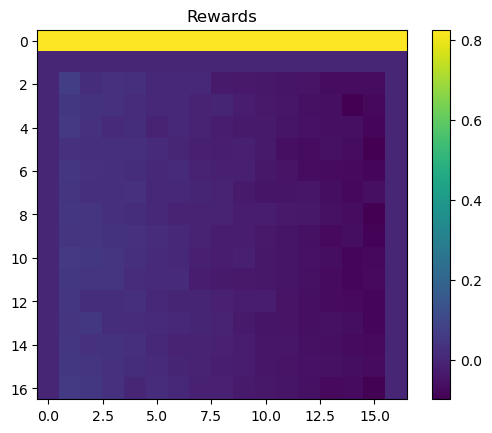

In [951]:
plt.imshow(rewards)
plt.colorbar()
plt.title('Rewards')

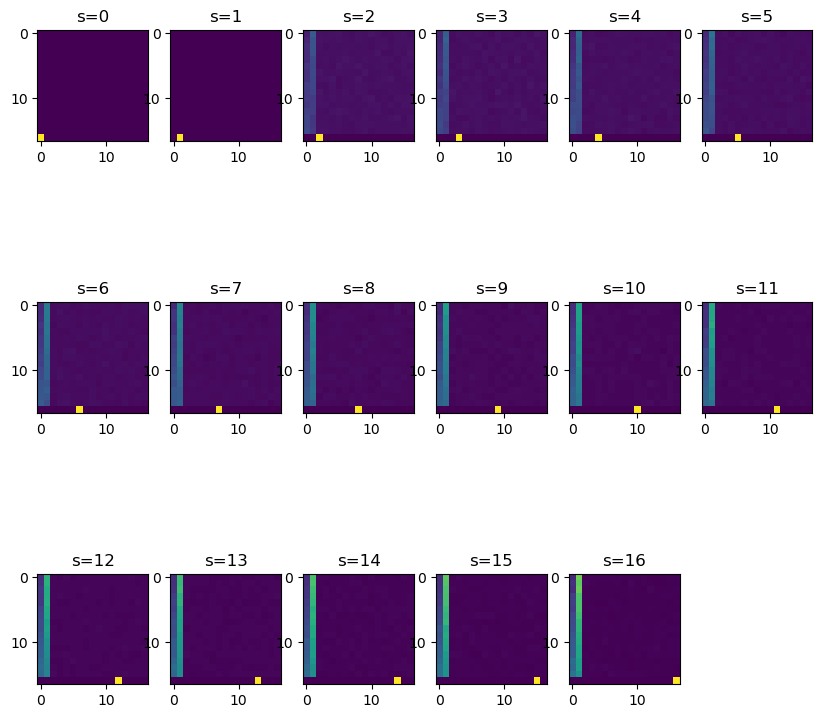

In [952]:
plt.figure(figsize = (10,10))
for i in range(17):
    plt.subplot(3,6,i+1)
    plt.imshow(transition[i])
    plt.title(f's={i}')


In [953]:
class MDP:
    def __init__(self, gamma, S, A, T, R):
        self.gamma = gamma
        self.S = S
        self.A = A
        self.T = T
        self.R = R

In [954]:
def lookahead(MDP, U, s, a):
    'Performs one step lookahead for taking action a from state s using estimate U from problem MDP'
    S,T,R,gamma = MDP.S, MDP.T, MDP.R, MDP.gamma
    return R[s,a] + gamma*sum(T[s,a,sp]*U[i] for i,sp in enumerate(S))

In [955]:
def greedy(MDP, U, s):
    'Returns best action and value function for state s and estimated U'
    u = np.max([lookahead(MDP, U, s, a) for a in A])
    a = np.argmax([lookahead(MDP, U, s, a) for a in A])
    return u,a

class ValueFunctionPolicy:
    def __init__ (self, MDP, U):
        self.MDP = MDP
        self.U = U
        
    def __call__(self, s):
        return greedy(self.MDP, self.U, s)

In [956]:
def backup(MDP, U, s):
    'Returns improved utility function by performing Bellman backup'
    return np.max([lookahead(MDP, U, s, a) for a in MDP.A])

In [957]:
class value_iteration:
    def __init__(self, k_max):
        self.k_max = k_max
        
def solve(M, MDP):
    'Returns ValueF'
    U = [0.0 for s in MDP.S]
    for k in np.arange(M.k_max):
        U = [backup(MDP, U, s) for s in MDP.S]
    return ValueFunctionPolicy(MDP, U)

In [958]:
S = np.arange(17)
A = np.arange(17)

In [959]:
# Declare MDP problem with gamma = 0.95
problem = MDP(1, S, A, transition, rewards)
M = value_iteration(200) # runs value iteration for 200 iterations


In [960]:
# Solve MDP by performing value iteration for 200 iterations
st = time.time()
solution = [solve(M, problem)(s) for s in S]
et = time.time()
print(f'{M} iterations of value iteration performed in {et - st} seconds')
best_policy = [s[1] for s in solution]
best_policy[1] = 16
U_vi = [s[0] for s in solution]

<__main__.value_iteration object at 0x28b9a04f0> iterations of value iteration performed in 4.153187990188599 seconds


In [961]:
best_policy

[16, 16, 15, 14, 14, 15, 15, 13, 15, 15, 14, 15, 14, 14, 15, 15, 15]

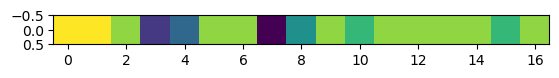

In [930]:
plt.imshow(np.array(best_policy).reshape(1,-1))

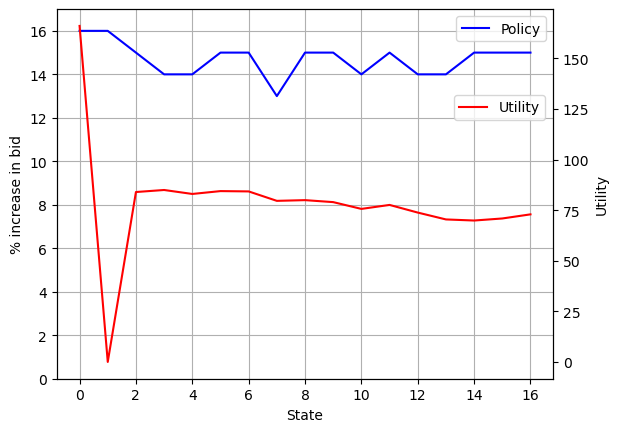

In [962]:
fig, ax1 = plt.subplots()
ax1.plot(best_policy, color = 'blue', label = 'Policy')
ax1.grid()
ax1.set_ylim(0,17)
ax2 = ax1.twinx()
ax2.plot(U_vi, color = 'red', label = 'Utility')
ax1.legend()
ax1.set_ylabel('% increase in bid')
ax2.set_ylabel('Utility')
ax1.set_xlabel('State')
ax2.legend(loc = (0.8, 0.7))



## Q-LEARNING

In [963]:
class QLearning:
    def __init__(self, S, A, gamma, Q, alpha):
        self.S = S
        self.A = A
        self.gamma = gamma
        self.Q = Q
        self.alpha = alpha
        
def lookahead(model, s, a):
    return model.Q[s, a]

def update(model, s, a, r, sp):
    gamma, Q, alpha = model.gamma, model.Q, model.alpha
    Q[s,a] += alpha*(r + gamma*np.max(Q[sp,:]) - Q[s,a])
    return model

In [1016]:
def simulate(samples, model, h, epsilon, decay):
    '''
    Args
        samples: s,a,r,sp dataset
        model: QLearning model class
        pi: EpsilonGreedyExploration class and callable
        h: # passes through dataset
        epsilon: probability of sampling random action from available actions from state s
        decay: decay rate of epsilon
    
    Returns updated Q learning model
    
    '''
    
    S = 17
    A = 17
    
    for it in range(h):
        epsilon = epsilon
        for i in range(len(samples)):
            s = samples.s[i] # sample starting state
            if (np.random.rand() < epsilon) & (s > 1):
                a = np.random.choice(np.arange(A-1))
                sp = np.random.choice(S, 1, list(transition[s,a]))
                r = np.random.choice(samples[(samples.s == s)&(samples.a == a)].r)
            else:
                a = np.argmax(model.Q[s,:])
                sp = np.random.choice(S, 1, list(transition[s,a]))
                r = np.random.choice(samples[(samples.s == s)&(samples.a == a)].r)
            
            epsilon = decay*epsilon # decay the epsilon by decay factor
            #sampling_index = np.random.choice(np.array(np.where((samples.s == s)&(samples.a == a))).ravel()) # sample an index from the dataset where action a is taken in state s
            #sp, r = samples.iloc[sampling_index, :].sp, samples.iloc[sampling_index, :].r
            update(model, s, a, r, sp)
            #s = sp
    return model

In [1017]:
S = np.arange(17)
A = np.arange(17)
Ui = np.zeros(len(S)) # initial U
gamma = 1
Q = np.zeros((len(S), len(A)))

In [1018]:
model = QLearning(S, A, gamma, Q, 0.01)
#pi = EpsilonGreedyExploration(0.1, 0.9)
st = time.time()
Q = simulate(df, model, 10, 0.33, 0.9).Q
et = time.time()
print(f'One pass through the dataset takes {et - st} seconds.')

ValueError: 'a' cannot be empty unless no samples are taken

In [1012]:
Q_policy = [np.argmax(Q[s,:]) for s in range(Q.shape[0])]

In [1013]:
U = [np.max(Q[s,:]) for s in range(Q.shape[0])]


In [1014]:
Q_policy

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

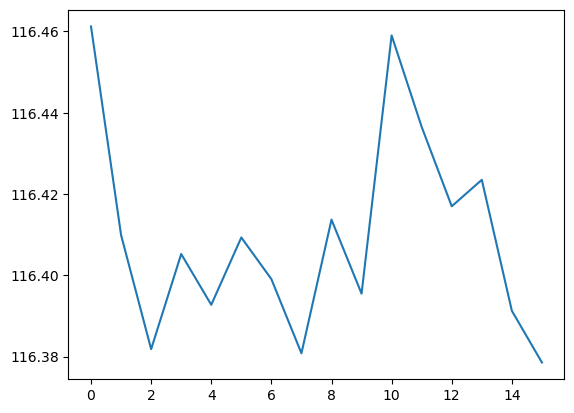

In [1015]:
plt.plot(U[1:])

In [476]:
def optimal_policy_sim(list_price, budget, verbose = 1):
    count = 1
    main_bid = np.random.normal(list_price, 0.15*list_price, 1) # generates our bid
    agent_budgets = list_price + np.random.choice(np.arange(-0.2, 0.5, 0.01), 4)*list_price
    if verbose: print(f'Budgets of all agents = {agent_budgets}. Our budget = {budget}')
    agent_bids = np.append(generate(list_price, agent_budgets, np.array([0,0,0,0])), main_bid) # generates all the bids
    
    rounds = np.zeros((5,5)) # initializing matrix holding all bids for all rounds
    rounds[0,:] = agent_bids
    if verbose: print(f'Round {count} bids at listing price of ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}' )
    if verbose: print('------------------------------------------------------------------------- \n')
    
    s = []
    a = []
    r = []
 
    while raise_bid(list_price, agent_bids[:-1]) & (count < 5):
        
        # randomly choose continuation state and increase list price correspondingly
        state = choose_state() 
        s += [state] 
        list_price = new_list_price(state, list_price)
        
        # choose optimal action
        actions = np.arange(1, 1.16, 0.01) # 16 actions. 
        action = Q_policy[state] # randomly select action
        a += [action]
        main_bid = actions[action]*main_bid # Main-bid raised by the action
        
        if action > 0: # raise the bid by x%
            r += [float(budget - main_bid)/budget] #r(2,1:)
            
        else:
            r += [0] # Maintain the bid

        agent_bids = np.append(generate(list_price, agent_budgets, agent_bids), main_bid)
        count += 1
        if verbose: print(f'Asking for more offers - Round {count} ...')
        if verbose: print(f'Round {count}. New listing price: ${list_price}: \n {agent_bids}\n Our bid = ${int(main_bid)}')
        if verbose: print(f'Seller raise the price by {(state-1)}%')
        if verbose: print(f'We raise the bid by {action}%')
        if verbose: print('------------------------------------------------------------------------- \n')
    
    
    if main_bid == np.max(agent_bids):
        # if the our bid is accepted
        s += [0]
        r += [1 + (budget - main_bid)/budget]
        if verbose: print(f'Bidding stopped after {count} round(s). We won the the house at ${int(np.max(agent_bids))}! You are invited to the housewarming!! :D')
        if budget > main_bid:
            if verbose: print(f'We are ${int(budget - main_bid)} within budget')
        else:
            if verbose: print(f'We are ${int(main_bid - budget)} over budget')
    else:
        # if our bid is rejected
        s += [1]
        r += [0]
        if verbose: print(f'Bidding stopped after {count} round(s). House sold to maximum bidder at ${np.max(agent_bids):.2f}. Better luck next time ! :(')

    if count > 1:
        return pd.DataFrame({'s':s[:-1], 'a':a, 'sp':s[1:], 'r':r[:-1]}).append(pd.DataFrame({'s':s[-1], 'a':[16], 'sp':s[-1], 'r':r[-1]}))
    else:
        return pd.DataFrame({'s':s[0], 'a':[16], 'sp':s[0], 'r':r[-1]})
    

In [986]:
np.save('transition.npy', transition)

In [ ]:
np.save()